In [ ]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import datetime
from rocketpy import Environment, SolidMotor, Rocket, Flight
import openai
import os
import time
from rich.console import Console
from rich.markdown import Markdown
from dotenv import load_dotenv

load_dotenv()


# Database Evaluation

When designing software for data management, there are several things to consider. Let's go over some questions that we need to think about and then discuss our options.

### Who is going to be affected by this software?

I feel this question is actually fairly nuanced. We can imagine that this project is part of some operation and other projects in the operation are going to interface with this one. What they are going to do with the database is obviously something that will influence the design. If they are writing more software, then there's heuristics, and design philophies you want to adhere to. 

### What kind of data is going to be 'managed'?

We can divide the data into two groups: Structured and Unstructured. 
Structured data is well suited for a SQL database. The table below is an example of structured data.

|   | Time (s) | X (m) | Y (m) | Z (m) | Vx (m/s) | Vy (m/s) | Vz (m/s) | E0 | E1 | E2 | E3 | W1 (rad/s) | W2 (rad/s) | W3 (rad/s) |
|---|---------:|------:|------:|------:|---------:|---------:|---------:|---:|---:|---:|---:|----------:|----------:|----------:|
| 0 | 0.000000 |     0 |     0 |     0 | 0.000000 | 0.000000 | 0.000000 |  1 |  0 |  0 |  0 | -0.043619 |  0.000000 |  0.000000 |
| 1 | 0.001410 |     0 |     0 |     0 | 0.000000 | 0.000000 | 0.000000 |  1 |  0 |  0 |  0 | -0.043619 |  0.000000 |  0.000000 |
| 2 | 0.002819 |     0 |     0 |     0 | 0.000000 | 0.000000 | 0.000000 |  1 |  0 |  0 |  0 | -0.043619 |  0.000000 |  0.000000 |
| 3 | 0.005639 |     0 |     0 |     0 | 0.000000 | 0.000000 | 0.000000 |  1 |  0 |  0 |  0 | -0.043619 |  0.000000 |  0.000000 |
| 4 | 0.008458 |     0 |     0 |     0 | 0.000000 | 0.000000 | 0.000000 |  1 |  0 |  0 |  0 | -0.043619 |  0.000000 |  0.000000 |

If you know what data is going to be stored, and you know the format of the data, then NoSQL would never have been invented. Take this table for example:

Time  | X         | Y         | Z           | Note 1 | Note 2 | Note 3 | Note 4  
------|-----------|-----------|-------------|--------|--------|--------|---------|
945   | 53.245951 | 50.293343 | 1001.062361 | Lorem  | dolor  |        |         |
946   | 53.294339 | 50.361653 | 1001.683877 | ipsum  |        |        |         |
947   | 53.342727 | 50.429839 | 1002.304383 |        |        |        |         |
948   | 53.391115 | 50.497909 | 1002.923876 | lectus | elit   | sit    | malesua |
949   | 53.391649 | 50.498659 | 1002.930701 | arcu   | Nulla  | diam   |         |

We can clearly see that a constant 'band-aid-like' solution was used to try and accomodate the unstructured data. Storing unstructured data in a structured database table can lead to several challenges and drawbacks:

1. **Loss of Context:** Unstructured data is typically rich in context and may not fit neatly into fixed columns. When forced into a structured format, much of this context can be lost, leading to a reduction in the information's depth and nuance.

2. **Limited Search and Analysis:** Unstructured data lacks a predefined schema, making it difficult to perform effective searches and analyses. Traditional SQL queries are designed to work with structured data, so searching for specific information within unstructured data becomes inefficient and often ineffective.

3. **Data Integrity:** Unstructured data can vary greatly in format and content, making it challenging to ensure data consistency and integrity across the table. This can lead to inaccuracies, incomplete information, and difficulties in data validation.

4. **Scalability:** Unstructured data, when stored in structured tables, can quickly lead to database bloat and inefficiency. The addition of new columns to accommodate various types of unstructured content can impact performance and scalability.

5. **Inefficient Storage:** Unstructured data often contains a lot of redundancy and may require significant storage space when stored in a structured table. This inefficiency can increase storage costs and degrade overall system performance. When you do this, You slow down any query on that table.

6. **Complex Queries:** Analyzing unstructured data stored in structured tables requires complex and resource-intensive queries. This can slow down query performance and hinder real-time analytics.

7. **Maintenance Challenges:** Adding, modifying, or removing columns in structured tables to accommodate unstructured data can be complex and may require changes to application logic, queries, and data migration procedures.

8. **Semantic Mismatch:** Unstructured data doesn't easily conform to the semantic requirements of a structured database. This can result in data being stored in ways that don't accurately reflect its meaning or context.

9. **Reduced Flexibility:** Unstructured data may change in format or content over time. A structured table doesn't handle such changes well, leading to potential issues with data integrity and application compatibility.

10. **Lack of Standardization:** Unlike structured data, unstructured data lacks a standardized representation. Each piece of unstructured data might require its own handling, complicating data management and usage.

For these reasons, unstructured data is generally best suited for specialized storage solutions like NoSQL databases, document stores, or content management systems that are designed to handle its inherent flexibility and context.


## NoSQL vs. SQL

Let's look at how both databases types would store the data:



### PostgreSQL

Time  | X         | Y         | Z           | Note 1 | Note 2 | Note 3 | Note 4  
------|-----------|-----------|-------------|--------|--------|--------|---------|
945   | 53.245951 | 50.293343 | 1001.062361 | Lorem  | dolor  |        |         |
946   | 53.294339 | 50.361653 | 1001.683877 | ipsum  |        |        |         |
947   | 53.342727 | 50.429839 | 1002.304383 |        |        |        |         |
948   | 53.391115 | 50.497909 | 1002.923876 | lectus | elit   | sit    | malesua |
949   | 53.391649 | 50.498659 | 1002.930701 | arcu   | Nulla  | diam   |         |


### MongoDB

```mongo
[
  {
    "Time": 945,
    "X": 53.245951,
    "Y": 50.293343,
    "Z": 1001.062361,
    "Note 1": "Lorem",
    "Note 2": "dolor"
  },
  {
    "Time": 946,
    "X": 53.294339,
    "Y": 50.361653,
    "Z": 1001.683877,
    "Note 1": "ipsum"
  },
  {
    "Time": 947,
    "X": 53.342727,
    "Y": 50.429839,
    "Z": 1002.304383
  },
  {
    "Time": 948,
    "X": 53.391115,
    "Y": 50.497909,
    "Z": 1002.923876,
    "Note 1": "lectus",
    "Note 2": "elit",
    "Note 3": "sit",
    "Note 4": "malesua"
  },
  {
    "Time": 949,
    "X": 53.391649,
    "Y": 50.498659,
    "Z": 1002.930701,
    "Note 1": "arcu",
    "Note 2": "Nulla",
    "Note 3": "diam"
  }
]
```

In a SQL database we have the `Table`. In a NoSQL database, we have the `Collection`.
In a SQL database, we have the `Row`. In a NoSQL database, we have the `Document`.

<div class="note">

**Note:** I don't think this really matters but it seems correct to say one simulation would correspond to one document. However, it does not feel correct to say one simulation would correspond to one table.

</div>



Let's just ask ChatGPT for its opinion:


In [36]:

import time

openai.api_key = os.getenv("OPENAI_API_KEY")

completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo-16k-0613",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "list the strengths and weaknesses of both SQL and NoSQL databases"}
    ]
)

response = completion.choices[0].message['content']
typed_response = ""


markdown_response = f"\n\nResponse:\n\n{response}"
markdown = Markdown(markdown_response)
console = Console()
console.print(markdown)

Response:                                                                                                          

Sure, here are some general strengths and weaknesses of both SQL and NoSQL databases:                              

SQL:                                                                                                               

Strengths:                                                                                                         

 1 Structured data: SQL databases excel at handling structured and relational data, making them suitable for       
   complex queries and data integrity.                                                                             
 2 ACID compliance: SQL databases typically guarantee Atomicity, Consistency, Isolation, and Durability, ensuring  
   data reliability and transactional integrity.                                                                   
 3 Strong community support: SQL has been widely adopted and has a mature ecosystem with plenty of documentation   
   and support available.                                                                                          
 4 Well-suited for complex operations: SQL databases perform well with complex queries involving multiple tables   
   and relationships.                                                                                              

Weaknesses:                                                                                                        

 1 Scalability limitations: SQL databases may face challenges when scaling horizontally to handle massive amounts  
   of data or high traffic volumes.                                                                                
 2 Fixed schema: SQL databases enforce a fixed schema, making it difficult to handle unstructured or changing data.
 3 Limited flexibility: Adding new attributes or changing the structure of existing data can be time-consuming and 
   potentially require downtime.                                                                                   
 4 High upfront setup costs: SQL databases often require upfront planning and design, which can take time and      
   resources.                                                                                                      

NoSQL:                                                                                                             

Strengths:                                                                                                         

 1 Scalability and performance: NoSQL databases are designed for horizontal scaling, allowing them to handle larger
   volumes of data and traffic more efficiently.                                                                   
 2 Flexibility: NoSQL databases are schema-less, allowing for flexibility in modeling and accommodating diverse    
   data types.                                                                                                     
 3 Distributed data model: NoSQL databases store data in a distributed fashion, which provides high availability   
   and fault tolerance.                                                                                            
 4 Rapid development: NoSQL databases facilitate faster development due to their flexible nature and relaxed       
   consistency requirements.                                                                                       

Weaknesses:                                                                                                        

 1 Limited query functionality: NoSQL databases often have limited query capabilities compared to SQL, making      
   complex querying and reporting challenging.                                                                     
 2 Eventual consistency: NoSQL databases typically offer eventual consistency rather than immediate consistency,   
   which may lead to data inconsistencies in 

### Last But Not Least: My Opinion

- Obviously, the database has to be reliable (this says nothing about which database to use)
- We are going to have unstructured data (this one's actually a fact)
    - PostgreSQL (at least) has a json column type which could probably mitigate that issue
- The main focus should be that it's easy to work with (for whoever is developing the software that interacts with the database) and it can be extended

#### My Questions

**What is so special about the last row?**
It seems very 'single-purpose' to say that's the results and anyone else can go back and recreate the data to (hopefully) get the same results.

**Why would you not want to save all the data from the simulation?**
This just seems like a really bad idea that's probably very impractical



## RocketPy
I was going to use this to give a better demonstration but we don't need to really do all that. Somewhat relevant mock data would help though.

### Running the simulation

We setup the simulation and run it to output a CSV containing the flight data.

oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20230830/gfs_0p25_18z is not an available dataset"

Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2023-08-31 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -117.23475°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 478067.82 W    3650230.97 N
Launch Site UTM zone: 11S
Launch Site Surface Elevation: 78.9 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.913 km
Forecast Time Period: From  2023-08-30 12:00:00  to  2023-09-15 12:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 1.17 m/s
Surface Wind Direction: 231.79°
Surface Wind Heading: 64.37°
Surface Pressure: 999.13 hPa
Surface Temperature: 294.49 K
Surface Air Density: 1.182 kg/m³
Surface Speed of Sound: 344.02 m/s


Atmospheric Model Plots


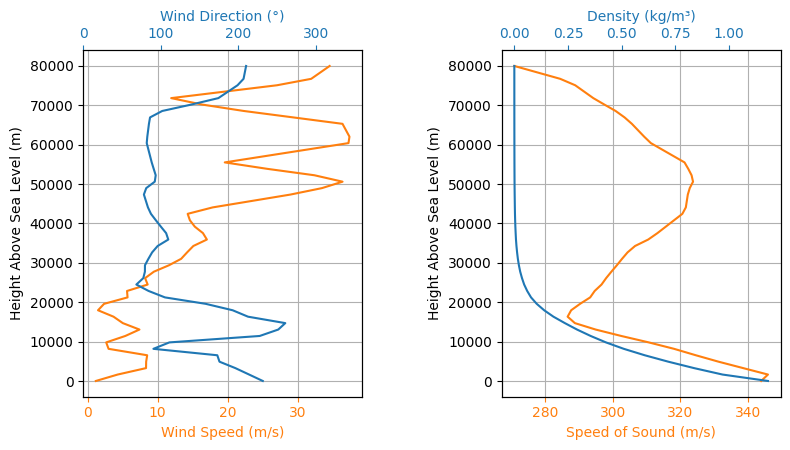


Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


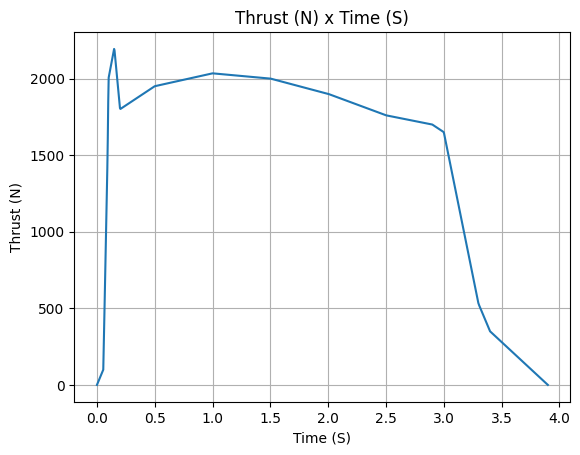

Inertia Details
Rocket Mass: 16.241 kg (No Propellant)
Rocket Mass: 19.197 kg (With Propellant)
Rocket Inertia I: 6.600 kg*m2
Rocket Inertia Z: 0.035 kg*m2

Geometrical Parameters
Rocket Maximum Radius: 0.0635 m
Rocket Frontal Area: 0.012668 m2

Rocket Distances
Rocket Center of Mass - Nozzle Exit Distance: -1.255 m
Rocket Center of Mass - Motor reference point: -0.85704 m
Rocket Center of Mass - Rocket Loaded Center of Mass: -0.132 m

Aerodynamic Components Parameters
Currently not implemented.

Aerodynamics Lift Coefficient Derivatives
Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 5.145/rad
Tail Lift Coefficient Derivative: -1.061/rad

Aerodynamics Center of Pressure
Nose Cone Center of Pressure to CM: 0.999 m
Fins Center of Pressure to CM: -1.105 m
Tail Center of Pressure to CM: -1.223 m
Distance - Center of Pressure to CM: -0.392 m
Initial Static Margin: 2.051 c
Final Static Margin: 3.090 c

Mass Plots


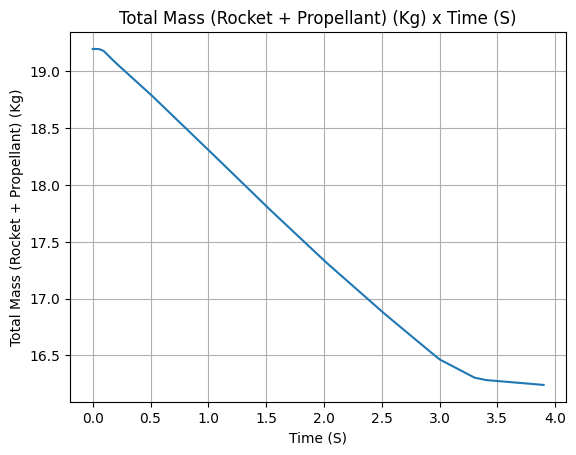

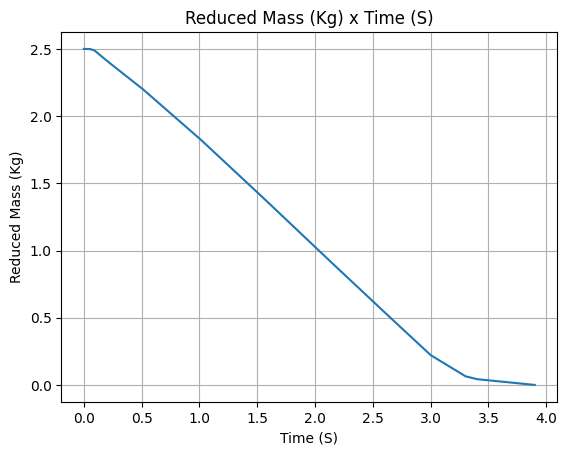


Aerodynamics Plots


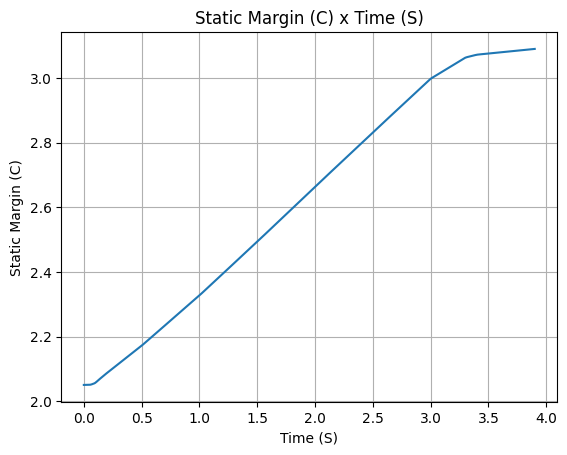

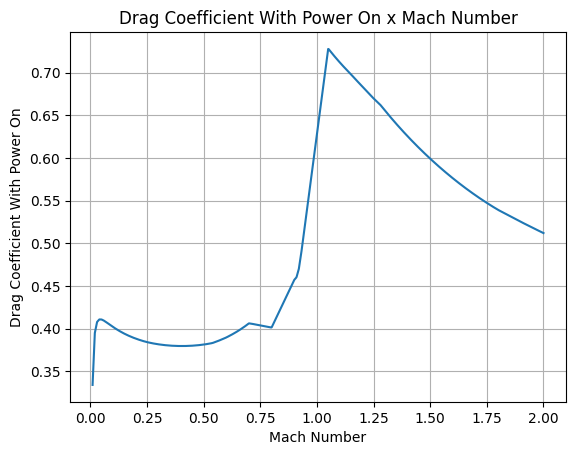

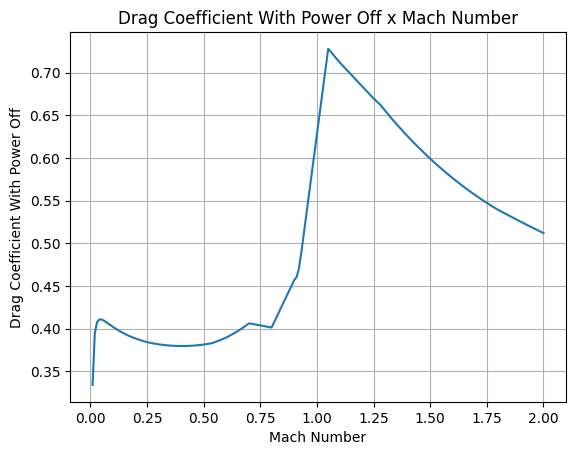

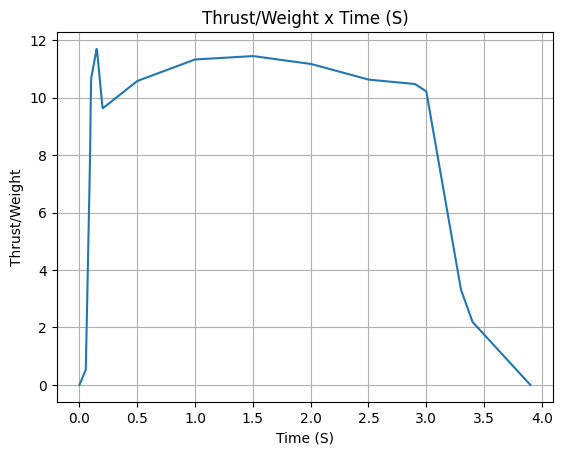

In [37]:

env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-117.234754, elevation=1400
)
tomorrow = datetime.date.today() + datetime.timedelta(days=1)
env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))
env.setAtmosphericModel(type="Forecast", file="GFS")
env.info()

Pro75M1670 = SolidMotor(
    thrustSource="./data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)
Pro75M1670.info()

Calisto = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="./data/calisto/powerOffDragCurve.csv",
    powerOnDrag="./data/calisto/powerOnDragCurve.csv",
)

Calisto.setRailButtons([0.2, -0.5])

NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addTrapezoidalFins(
    n=4,
    rootChord=0.120,
    tipChord=0.040,
    span=0.100,
    distanceToCM=-1.04956,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = Calisto.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)
Calisto.allInfo()


def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


Main = Calisto.addParachute(
    "Main",
    CdS=10.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = Calisto.addParachute(
    "Drogue",
    CdS=1.0,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
TestFlight = Flight(rocket=Calisto, environment=env, inclination=85, heading=0)
TestFlight.exportData("./output/testFlight.csv")

In [38]:
# Load CSV into a Pandas DataFrame
file_path = "./output/testFlight.csv"
df = pd.read_csv(file_path)
df.tail()

,# Time (s),X (m),Y (m),Z (m),Vx (m/s),Vy (m/s),Vz (m/s),E0,E1,E2,E3,W1 (rad/s),W2 (rad/s),W3 (rad/s)
934,53.250180,-24.614614,994.593411,111.667545,0.444821,12.800004,-198.933460,0.029574,-0.969641,-0.242653,-0.006567,0.000976,-0.006185,0.0
935,53.293566,-24.595314,995.148343,103.034141,0.444801,12.781470,-199.052769,0.029562,-0.969641,-0.242656,-0.006438,0.000818,-0.005559,0.0
936,53.336951,-24.576015,995.702471,94.395575,0.444799,12.762917,-199.171397,0.029550,-0.969641,-0.242660,-0.006323,0.000645,-0.004916,0.0
937,53.380337,-24.556714,996.255793,85.751878,0.444942,12.744373,-199.289342,0.029538,-0.969642,-0.242663,-0.006222,0.000497,-0.004397,0.0
938,53.414716,-24.541411,996.693681,78.898897,0.445226,12.729699,-199.382317,0.029528,-0.969642,-0.242665,-0.006149,0.000418,-0.004143,0.0


## PostGreSQL
Here we are going to create a table in PostgreSQL that will hold the flight data in a table.

In [46]:
# Database credentials
db_credentials = {
    "dbname": os.getenv("PG_DATABASE"),
    "user": os.getenv("PG_USERNAME"),
    "password": os.getenv("PG_PASSWORD"),
    "host": os.getenv("PG_HOSTNAME"),
    "port": os.getenv("PG_PORT")
}

# Create a connection to the Postgres database
engine = create_engine(
    f"postgresql+psycopg2://{db_credentials['user']}:{db_credentials['password']}@{db_credentials['host']}:{db_credentials['port']}/{db_credentials['dbname']}"
)

# Write the DataFrame to Postgres table
df.to_sql("flight-data", engine, if_exists="replace", index=False)

print("Data successfully written to original Postgres table.")

# Get the last row of the DataFrame
last_row_df = df.tail(1)

# Write the last row to a new Postgres table
last_row_df.to_sql("results", engine, if_exists="replace", index=False)

print("Last row successfully written to new Postgres table.")

Data successfully written to original Postgres table.
Last row successfully written to new Postgres table.


## MongoDB (NoSQL)
Here we are going to create a document in MongoDB that will hold the flight data in a table.


In [45]:
import pandas as pd
from pymongo import MongoClient

file_path = "./output/testFlight.csv"
df = pd.read_csv(file_path)

print(type(os.getenv("MONGO_HOST")))

# MongoDB credentials and settings
mongo_settings = {
    'host': os.getenv("MONGO_HOST"),
    'port': os.getenv("MONGO_PORT"),
    'password': os.getenv("MONGO_PASSWORD"),
    'dbname': os.getenv("MONGO_DB_NAME"),
    'collection_name': os.getenv("MONGO_COLLECTION"),
    'username': os.getenv("MONGO_USERNAME")
}

# Create a MongoDB client and connect to the database with authentication
client = MongoClient(
    f"mongodb://{mongo_settings['username']}:{mongo_settings['password']}@{mongo_settings['host']}:{mongo_settings['port']}/")
db = client[mongo_settings['dbname']]
collection = db[mongo_settings['collection_name']]

# Convert each row in the DataFrame to a dictionary and store it in a list
time_step_data = [row.to_dict() for _, row in df.iterrows()]

# Create a single document with a 'timesteps' field containing the list of time step data
document = {'timesteps': time_step_data}

# Insert this single document into MongoDB
collection.insert_one(document)

print("Data successfully written to MongoDB collection.")

# Optionally, write the last row to a new MongoDB collection
last_row_df = df.tail(1)
last_row_records = last_row_df.to_dict(orient='records')
new_collection = db['results']
new_collection.insert_many(last_row_records)

print("Last row successfully written to new MongoDB collection.")

<class 'str'>
Data successfully written to MongoDB collection.
Last row successfully written to new MongoDB collection.


In [51]:
conn = psycopg2.connect(
    dbname = os.getenv("PG_DATABASE"),
    user = os.getenv("PG_USERNAME"),
    password = os.getenv("PG_PASSWORD"),
    host = os.getenv("PG_HOSTNAME"),
    port = os.getenv("PG_PORT")
)

cursor = conn.cursor()
cursor.execute('SELECT * FROM "flight-data" WHERE "# Time (s)" > 50;')
rows = cursor.fetchall()
cursor.close()
conn.close()

for row in rows:
    print(row)

(50.011613, -26.154456, 950.994096, 739.193999, 0.528946, 14.095995, -187.844534, 0.031795, -0.969565, -0.242549, -0.01016, -0.003142, 0.001568, 0.0)
(50.068198, -26.124574, 951.791131, 728.558163, 0.527157, 14.075135, -188.07696, 0.031713, -0.969568, -0.242547, -0.010228, -0.003779, 0.001742, 0.0)
(50.124784, -26.094797, 952.586986, 717.909212, 0.525185, 14.054283, -188.308032, 0.031613, -0.969571, -0.242544, -0.010306, -0.004487, 0.00199, 0.0)
(50.181369, -26.065134, 953.38166, 707.247224, 0.52319, 14.03329, -188.537763, 0.031497, -0.969575, -0.242541, -0.010397, -0.00502, 0.002225, 0.0)
(50.237955, -26.035584, 954.17514, 696.572275, 0.52133, 14.012033, -188.766167, 0.031371, -0.969579, -0.242537, -0.010496, -0.005189, 0.002358, 0.0)
(50.29454, -26.006134, 954.96741, 685.884439, 0.519686, 13.99047, -188.993247, 0.031246, -0.969583, -0.242534, -0.010596, -0.004939, 0.002341, 0.0)
(50.351125, -25.976772, 955.758452, 675.183792, 0.518221, 13.968663, -189.218998, 0.031132, -0.969586, -0.

In [52]:
mongo_settings = {
    'host': os.getenv("MONGO_HOST"),
    'port': os.getenv("MONGO_PORT"),
    'password': os.getenv("MONGO_PASSWORD"),
    'dbname': os.getenv("MONGO_DB_NAME"),
    'collection_name': os.getenv("MONGO_COLLECTION"),
    'username': os.getenv("MONGO_USERNAME")
}

# Create a MongoDB client and connect to the database with authentication
client = MongoClient(
    f"mongodb://{mongo_settings['username']}:{mongo_settings['password']}@{mongo_settings['host']}:{mongo_settings['port']}/")
db = client[mongo_settings['dbname']]
collection = db[mongo_settings['collection_name']]

# Query to find a document and then retrieve time steps where "Time" is greater than 50
document = collection.find_one({})  # Assuming there's only one document as per your structure
filtered_timesteps = [ts for ts in document['timesteps'] if ts['# Time (s)'] > 50]

# Process the filtered time steps
for ts in filtered_timesteps:
    print(ts)

{'# Time (s)': 50.015056, 'X (m)': 45.385965, 'Y (m)': 957.374797, 'Z (m)': 734.309956, 'Vx (m/s)': 1.635014, 'Vy (m/s)': 14.157506, 'Vz (m/s)': -187.995238, 'E0': 0.031492, 'E1': -0.976177, 'E2': -0.214431, 'E3': -0.011385, 'W1 (rad/s)': -0.00376, 'W2 (rad/s)': 0.002979, 'W3 (rad/s)': 0.0}
{'# Time (s)': 50.068475, 'X (m)': 45.473205, 'Y (m)': 958.130539, 'Z (m)': 724.261689, 'Vx (m/s)': 1.630908, 'Vy (m/s)': 14.137672, 'Vz (m/s)': -188.213942, 'E0': 0.031404, 'E1': -0.976179, 'E2': -0.214427, 'E3': -0.011498, 'W1 (rad/s)': -0.004673, 'W2 (rad/s)': 0.004322, 'W3 (rad/s)': 0.0}
{'# Time (s)': 50.076001, 'X (m)': 45.485478, 'Y (m)': 958.23693, 'Z (m)': 722.845057, 'Vx (m/s)': 1.630308, 'Vy (m/s)': 14.134871, 'Vz (m/s)': -188.244657, 'E0': 0.03139, 'E1': -0.976179, 'E2': -0.214426, 'E3': -0.011518, 'W1 (rad/s)': -0.004799, 'W2 (rad/s)': 0.004516, 'W3 (rad/s)': 0.0}
{'# Time (s)': 50.083527, 'X (m)': 45.497746, 'Y (m)': 958.3433, 'Z (m)': 721.428194, 'Vx (m/s)': 1.629707, 'Vy (m/s)': 14.1